{'record_name': 'voice001', 'n_sig': 1, 'fs': 8000, 'counter_freq': None, 'base_counter': None, 'sig_len': 38080, 'base_time': None, 'base_date': None, 'comments': ['<age>: 32  <sex>: M <diagnoses>: hyperkinetic dysphonia <medications>: none'], 'sig_name': ['voice'], 'p_signal': array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       ...,
       [ 0.00354004],
       [-0.03735352],
       [-0.02871704]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['voice001.dat'], 'fmt': ['32'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [4079702243.3775], 'baseline': [-260023747], 'units': ['NU'], 'adc_res': [0], 'adc_zero': [0], 'init_value': [-260023747], 'checksum': [14973], 'block_size': [0]}


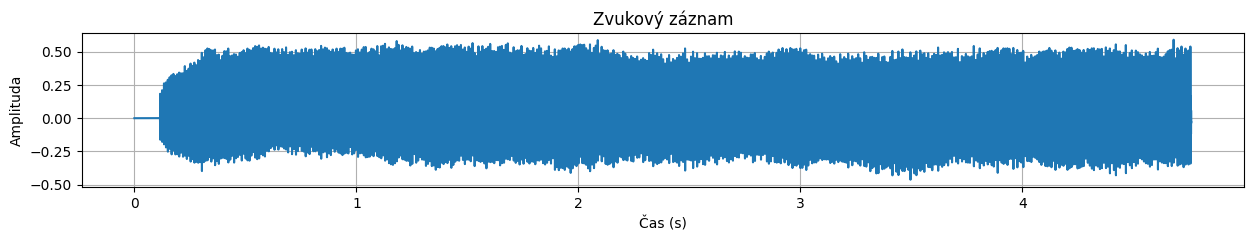

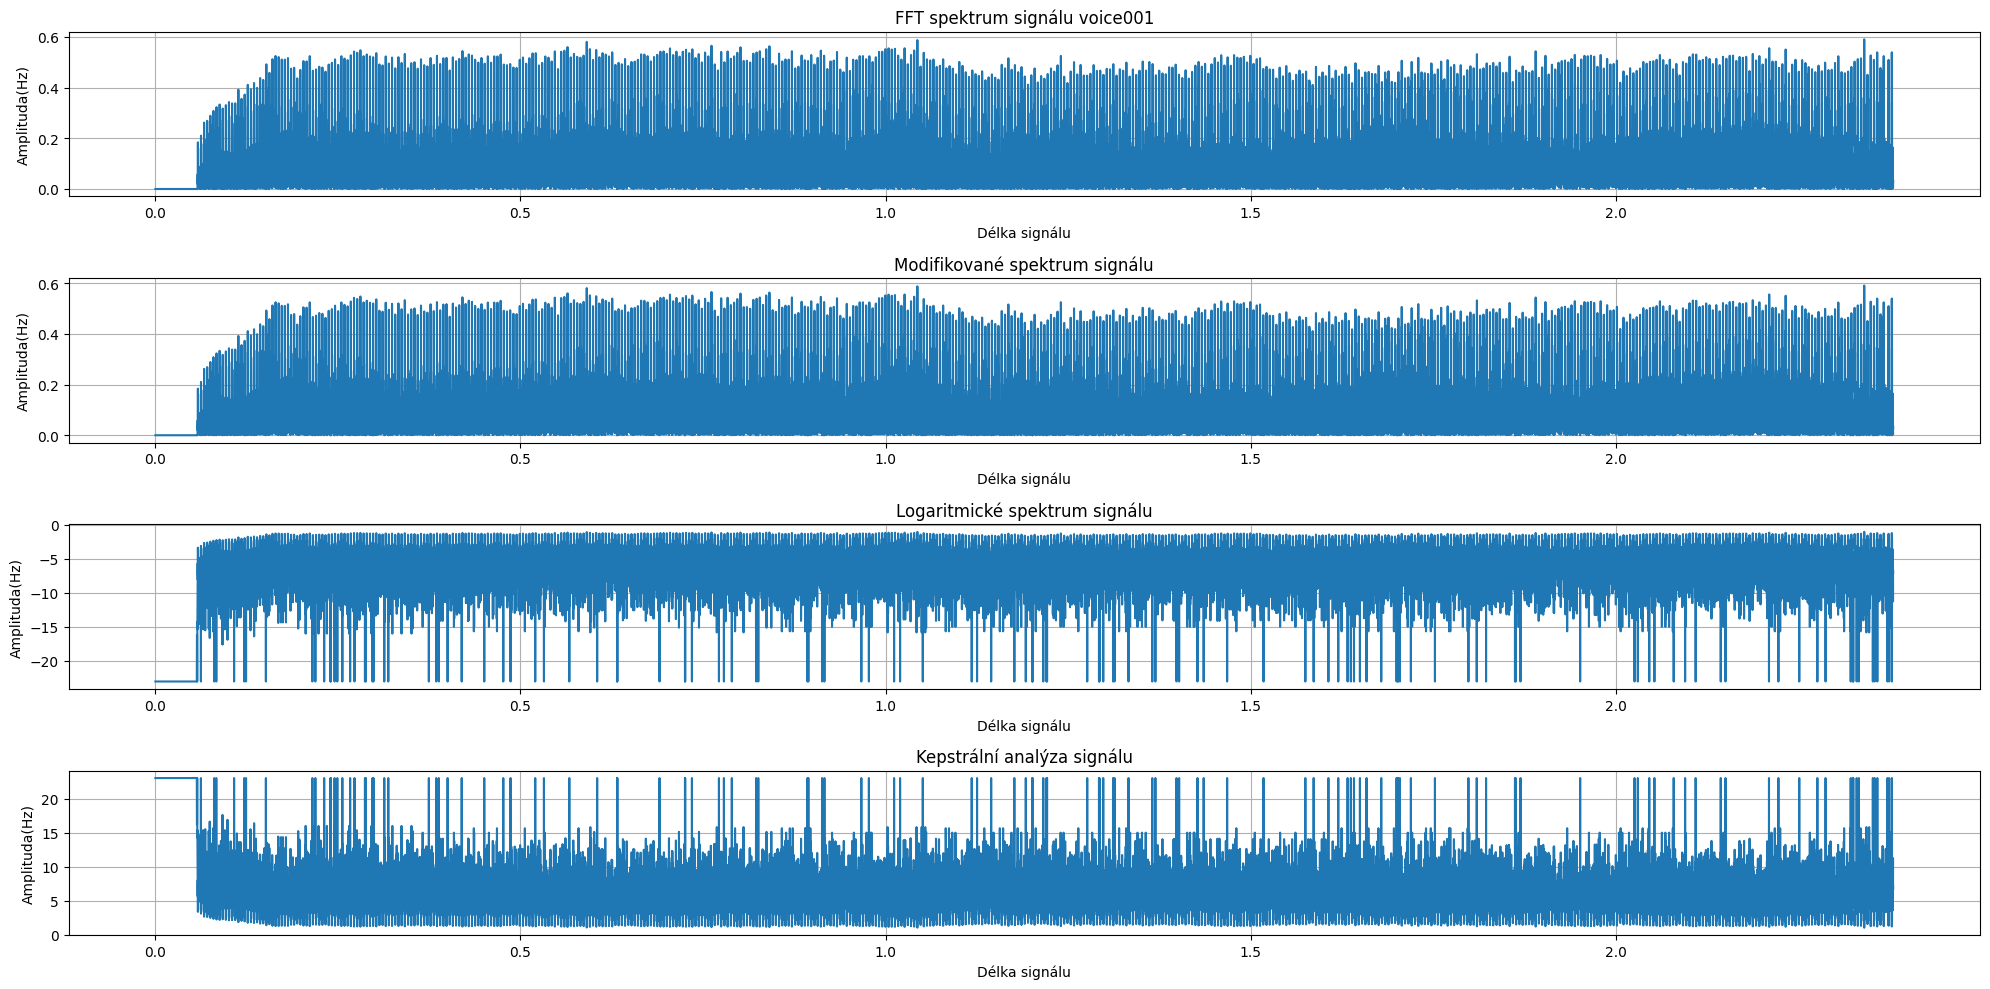

{'min_value': np.float64(0.0), 'max_value': np.float64(0.5901184082510088), 'mean_value': np.float64(0.08729901193525427), 'std_value': np.float64(0.09664522741174052), 'is_pathological': np.False_}


C:\Users\Patrik\AppData\Local\Temp\ipykernel_3588\2898874406.py:139: UserWarning: Input data is complex, switching to return_onesided=False
  f, t, Zxx = stft(np.fft.fft(signal),fs=vz_f, nperseg=256)


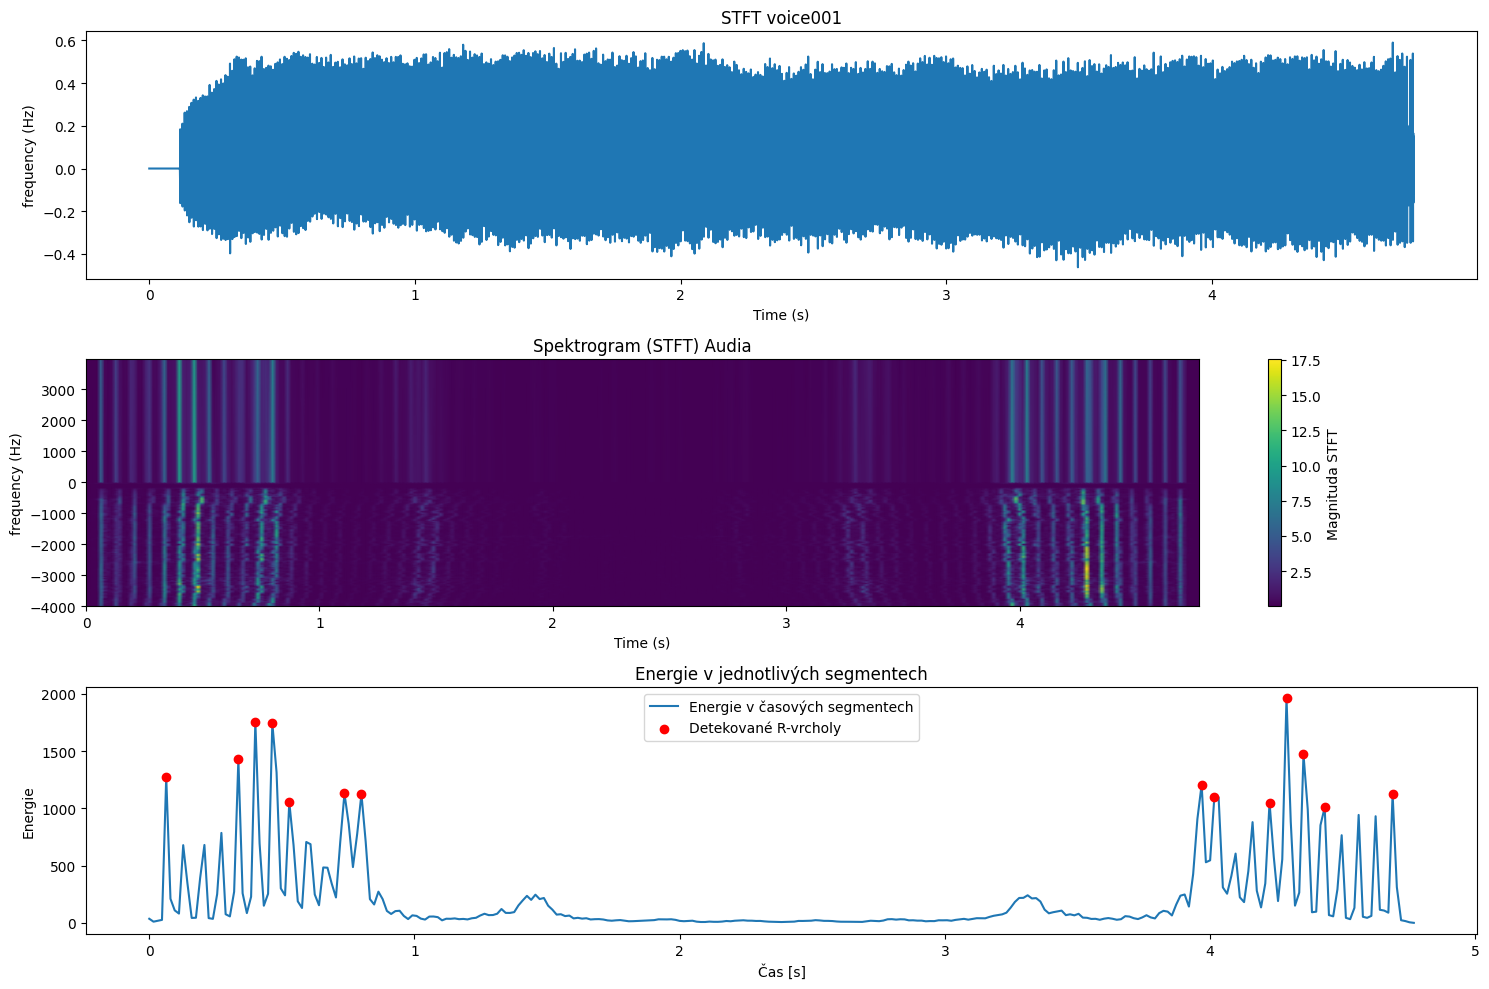

voice001 pathologicity - False
voice002 pathologicity - True
voice003 pathologicity - False
voice004 pathologicity - False
voice005 pathologicity - False
voice006 pathologicity - False
voice007 pathologicity - False
voice008 pathologicity - False
voice009 pathologicity - False
voice010 pathologicity - True
voice011 pathologicity - False
voice012 pathologicity - False
voice013 pathologicity - False
voice014 pathologicity - False
voice015 pathologicity - False
voice016 pathologicity - False
voice017 pathologicity - False
voice018 pathologicity - True
voice019 pathologicity - False
voice020 pathologicity - False
voice021 pathologicity - False
voice022 pathologicity - True
voice023 pathologicity - False
voice024 pathologicity - False
voice025 pathologicity - False
voice026 pathologicity - False
voice027 pathologicity - False
voice028 pathologicity - False
voice029 pathologicity - False
voice030 pathologicity - False
voice031 pathologicity - True
voice032 pathologicity - True
voice033 patho

In [12]:
#úkol: klasifikace zvukových signálů na dobré a patologické pomocí různých technik pomocí Fourierovy a kepstrální analýzy,... v případe klasifikujte poruchy + porovnat s technikami které provedli experti
#výstup: grafy demostrující práci se signálem v časové nebo frekvenční oblasti, viualizace a klasifikace v prostoru nebo pomocí parametrů, tabulka s úspěšností klasifikace na jednotlivé skupiny a patologické signály.
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import stft, find_peaks

def Nacti_soubor(cesta_k_souboru): return wfdb.rdrecord(cesta_k_souboru)

#nejdřív si vykreslím zvukový signál
def plot_audio(time_axis,signal):
    plt.figure(figsize=(15, 2))
    plt.plot(time_axis, signal)
    plt.title("Zvukový záznam"); plt.xlabel("Čas (s)"); plt.ylabel("Amplituda")
    plt.grid()
    plt.show()
#aby se i audio dalo přehrát
def play_audio(signal, fs):
    import sounddevice as sd
    sd.play((signal*32767).astype(np.int16),samplerate=fs)
    sd.wait()

record = Nacti_soubor(r"C:\Users\Patrik\OneDrive\Plocha\PZS\seminarni_prace_2\zvukove_stopy\voice001") #načtu si zvukový soubor
print(f"{record.__dict__}") #Načtu si informace o zvukové nahrávce, abych věděl, co obsahuje.
signal = record.p_signal #vezmu si ze souboru signál zvuku
vz_f = record.fs #vzorkovací frekvence zvuku
time = len(signal)/vz_f #výpočet času audia
time_axis = np.linspace(0,time,len(signal)) #vytvořím časovou osu zvuku

plot_audio(time_axis,signal)
play_audio(signal, vz_f) 

def plot_fft_signal(fqs_axis, spectrum, peak_fqs, peaks, fqs2_axis, modified_spectrum, fqs3_axis, log_sp, fqs4_axis, cepstrum, signal_name):
    plt.figure(figsize=(20, 10))
    plt.subplot(4, 1, 1)
    plt.plot(fqs_axis, spectrum)
    plt.plot(peak_fqs,peaks, linestyle='None', marker='o', color='red', label="R-vrcholy")
    plt.title(f"FFT spektrum signálu {signal_name}")
    plt.xlabel("Délka signálu")
    plt.ylabel("Amplituda(Hz)")
    plt.grid()
    plt.subplot(4, 1, 2)
    plt.plot(fqs2_axis, modified_spectrum)
    plt.title(f"Modifikované spektrum signálu")
    plt.xlabel("Délka signálu")
    plt.ylabel("Amplituda(Hz)")
    plt.grid()
    plt.subplot(4, 1, 3)
    plt.plot(fqs3_axis, log_sp)
    plt.title("Logaritmické spektrum signálu")
    plt.xlabel("Délka signálu")
    plt.ylabel("Amplituda(Hz)")
    plt.grid()
    plt.subplot(4, 1, 4)
    plt.plot(fqs4_axis, cepstrum)
    plt.title("Kepstrální analýza signálu")
    plt.xlabel("Délka signálu")
    plt.ylabel("Amplituda(Hz)")
    plt.grid()
    plt.tight_layout()
    plt.show()

def Vypocet_prumerne_frekvence(amplitudy, dolni_mez):
    x_coords = [uV for uV in amplitudy if uV > dolni_mez] #vezmu všechny hodnoty frekvencí, které jsou delší než dolní mez frekvence
    if len(x_coords) > 0: #když měření bude obsahovat nějaké souřadnice
        prumer_x = sum(x_coords) / len(x_coords) #vypočítám si průměrnou hodnotu x vrcholů
        return prumer_x
    else: return 0

#fourierova transformace signálu
def fft_transform(signal, fs, down_limit, signal_range=0.2):
    _1D_f_t = np.fft.fft(signal) #fourierova transformace
    fft_spectrum = np.abs(_1D_f_t) #spektrum fourierovy transformace
    fqs_t = np.arange(len(signal))/fs*signal_range #osa frekvencí fourierovy transformace 
    
    #zde si vytvořím spektrum se smazanými vrcholy, které jsou vyšší než dolní hranice
    modified_spectrum = fft_spectrum.copy() #kopie spektra
    modified_spectrum[modified_spectrum>down_limit] = 0 #modifikace spektra
    
    log_sp = np.log(fft_spectrum**2+1e-10) #logaritmická verze spektra
    #inverzní fft
    invers_fft = np.abs(np.fft.ifft(log_sp)) #kepstrální analýza 2

    #zde budu detetokat abnormality u signálu
    peaks, _ = find_peaks(fft_spectrum[:, 0], height=down_limit) #najdem vrcholy, které jsou vyšší než dolní limit
    peak_fqs = fqs_t[peaks] #frekvence, kde jsou vrcholy
    peak_magnitudes = fft_spectrum[peaks] #magnitudy vrcholů

    return fqs_t, fft_spectrum, modified_spectrum, log_sp, invers_fft, peak_magnitudes, peak_fqs #vrátím data abych si mohl signál vykreslit

#Udělám si funkci, kde v daném spektru budu zjišťovat patologicitu, kam mi budou vstupovat meze pro minimální hodnotu, maximální hodnotu, průměr a směrodatnou odchylku
def count_fft_patholigicity(fft_spectrum, mean_threeshold, min_threeshold, max_threeshold, std_threeshold):
    #zjistím min, max hodnotu, prumernou hodnotu a smerodatnou odchylku ve spektru
    min_hodnota = np.min(fft_spectrum)
    max_hodnota = np.max(fft_spectrum)
    prum_hodnota = np.mean(fft_spectrum) 
    smd_odchylka = np.std(fft_spectrum)
    #uložím si je do seznamu
    stats = {"min_value": min_hodnota, "max_value": max_hodnota, "mean_value": prum_hodnota, "std_value": smd_odchylka}
    #budu zjitovat patologicitu pomocí booleanu
    is_pathological = (stats["min_value"] < min_threeshold or stats["max_value"] > max_threeshold or stats["mean_value"] > mean_threeshold or stats["std_value"] > std_threeshold)
    
    #poznamenám si do seznamu, že je patologický
    stats["is_pathological"] = is_pathological
    #vrátím seznam s informacemi
    return stats

peaks_limit = 0.8 #nastavím si dolní hranici pro vrcholy např.: 0.5 Hz

#zde jsem useknul přes fourierovu transformaci frekvence vyšší než 0.5 Hz
fqs, spectrum, modified_spectrum, log_spectrum, ifft_spectrum, peaks, peak_fqs = fft_transform(signal,vz_f,peaks_limit, signal_range=0.5)

#vykreslím si grafy signálů
plot_fft_signal(fqs,spectrum,peak_fqs,peaks,fqs,modified_spectrum,fqs,log_spectrum, fqs, ifft_spectrum, signal_name=record.record_name)

#použiju funkci pro zjištění signálu, jestli je patologický
is_pathological = count_fft_patholigicity(spectrum, mean_threeshold=0.2,min_threeshold=-1,max_threeshold=1,std_threeshold=0.5)
print(is_pathological)

#inverzní fft2, pomocí funkce z knihovny scipy 2. způsob
def inverse_fft2(signal, fs):
    spectrum = np.abs(fft(signal)) #udělám fourierovu transformaci
    fft_axis = np.arange(len(signal))/fs
    log_sp = np.log(spectrum)#+np.finfo(float).eps) #zlogaritmování + přidání eps pro přesnost
    invers_fft = np.abs(ifft(log_sp)) #kepstrální analýza
    ifft_time_axis = np.arange(len(invers_fft))/fs #vytvoření časové osy pro kepstrální analýzu
    return fft_axis, spectrum, log_sp, ifft_time_axis, invers_fft

#fft_time, spectrum, log_sp, ifft_time_axis, invers_fft = inverse_fft2(signal,vz_f)
#plot_fft_signal(fft_time,spectrum,peak_fqs,peaks, fft_time, spectrum, fft_time, log_sp, fft_time, invers_fft, signal_name=record.record_name)
#play_audio(inverse_fft_,vz_f)

#short time fouriers transform

#aby jsme mohli s daty pracovat pole musí být 1d
if signal.ndim > 1: signal = signal.mean(axis=1) 

f, t, Zxx = stft(np.fft.fft(signal),fs=vz_f, nperseg=256)
energy=np.sum(np.abs(Zxx),axis=0)
peaks, _ = find_peaks(energy,height=np.max(energy)*0.5)

def plot_stft(time_axis, signal, f, t, Zxx, peaks, signal_name):
    plt.figure(figsize=(15, 10))
    plt.subplot(3,1,1)
    plt.plot(time_axis,signal)
    plt.title(f"STFT {signal_name}")
    plt.ylabel("frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.subplot(3, 1, 2)
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.colorbar(label='Magnituda STFT')
    plt.ylabel("frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title('Spektrogram (STFT) Audia')
    plt.subplot(3, 1, 3)
    plt.plot(t, energy, label='Energie v časových segmentech')
    plt.scatter(t[peaks], energy[peaks], color='red', label='Detekované R-vrcholy', zorder=5)
    plt.xlabel('Čas [s]')
    plt.ylabel('Energie')
    plt.title('Energie v jednotlivých segmentech')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_stft(time_axis, signal, f, t, Zxx, peaks, signal_name=record.record_name)

#vyzkouším další audio, dám si to do funkce, aby zkoušení mohlo být rychlejší
def read_plot_get_audio_pathologicity(audio_file):
    record = Nacti_soubor(audio_file)
    signal = record.p_signal 
    vz_f = record.fs 
    time = len(signal)/vz_f 
    time_axis = np.linspace(0,time,len(signal)) 

    plot_audio(time_axis,signal)
    #můžu si ho i zkusit přehrát
    #play_audio(signal, vz_f) 

    down_limit=0.8
    #provedu fft_transformace
    fqs, spectrum, modified_spectrum, log_spectrum, ifft_spectrum, peaks, peak_fqs = fft_transform(signal,vz_f,down_limit)

    #vykreslím si grafy signálů
    plot_fft_signal(fqs,spectrum,peak_fqs,peaks,fqs,modified_spectrum,fqs,log_spectrum, fqs, ifft_spectrum, signal_name=record.record_name)

    #vypíšu jestli je signál patologický
    is_pathological = count_fft_patholigicity(spectrum, mean_threeshold=0.2,min_threeshold=-1,max_threeshold=1,std_threeshold=0.5)
    #pro kontrolu si vypíši data
    print(f"{record.record_name} - {is_pathological}")

#read_plot_get_audio_pathologicity(r"C:\Users\Patrik\OneDrive\Plocha\PZS\seminarni_prace_2\zvukove_stopy\voice002")

#funkce, která pouze změří jestli to je patologický
def get_audio_pathologicity(audio_file):
    record = Nacti_soubor(audio_file)
    signal = record.p_signal 
    vz_f = record.fs 
    time = len(signal)/vz_f 
    time_axis = np.linspace(0,time,len(signal)) 

    down_limit=0.8
    #provedu fft_transformace
    fqs, spectrum, modified_spectrum, log_spectrum, ifft_spectrum, peaks, peak_fqs = fft_transform(signal,vz_f,down_limit)

    #vypíšu jestli je signál patologický
    is_pathological = count_fft_patholigicity(spectrum, mean_threeshold=0.2,min_threeshold=-1,max_threeshold=1,std_threeshold=0.5)
    print(f"{record.record_name} pathologicity - {bool(is_pathological["is_pathological"])}")
    return is_pathological["is_pathological"]

import os
#pokusím se zjistit patologicitu u všech audií ve složce
def test_all_audio(dirname):
    #v celém audiu zjistím kolik mi to našlo patologických a kolik nepatologických
    stats = {"nepatologicky": 0, "patologicky": 0}
    for file_name in os.listdir(dirname):
        file_path = os.path.join(dirname, file_name)  
        # Kontrola, zda je soubor zvukového formátu (např. .hea nebo .dat)
        if file_name.endswith(".hea"):
            #pro načtetení souboru použiji try except
            try:
                #zavolám funkci, která u audia zjišťuje, když je to patologický 
                pathologicity = get_audio_pathologicity(file_path[:-4])
                if bool(pathologicity): stats["patologicky"]+=1 
                else: stats['nepatologicky']+=1
            except Exception as e: print(f"Chyba při načítání souboru {file_name}: {e}")
    print(stats)

test_all_audio(r"C:\Users\Patrik\OneDrive\Plocha\PZS\seminarni_prace_2\zvukove_stopy")
#zjistilo mi to 38 patologických signálů z 205